In [159]:
# import packages
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error as mse

from statsmodels.stats.contingency_tables import mcnemar

import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

In [18]:
# set flag for which metric we are calibrating LR with
# possible values are 'point diff', 'point ratio', 'pythagorean point ratio', 'dsr', 
# 'game control', 'game control signed', 'game control avg', 'game control fourth'
METRIC = 'game control avg'

In [19]:
# create dataframe containing home team, away team, point differential (home - away, 0 if OT)
games = nfl.import_schedules([2022, 2021, 2019, 2018, 2017, 2016, 2015])
games.dropna(axis=0)
games['home_team'].replace({'SD': 'LAC', 'OAK': 'LV', 'STL': 'LA'}, inplace=True)
games['away_team'].replace({'SD': 'LAC', 'OAK': 'LV', 'STL': 'LA'}, inplace=True)
games['result'] = [0 if row['overtime'] else row['result'] for (index, row) in games.iterrows()] # replace overtime scores with 0

# merge ingame_stats dataframe
ingame_stats = pd.read_csv('data/ingame_stats.csv')
games = games.merge(ingame_stats, 'inner', ['game_id', 'home_team', 'away_team'])

nfldata = games[games['season'] != 2022][[
    'away_team', 'home_team', 'away_score', 'home_score', 'total', 'result', 'overtime', 'div_game', 'game_type', 'season', 'gameday',
    'home_dsr', 'away_dsr', 'home_gc', 'away_gc', 'home_gc_signed', 'away_gc_signed', 'home_gc_avg', 'away_gc_avg', 
    'home_gc_fourthqtr', 'away_gc_fourthqtr'
    ]]
# throw out final week games?

# plt.hist(nfldata['result'], bins=len(set(nfldata['result'])))
# plt.xticks(range(-39, 40, 3), fontsize=8, rotation=90) # how were plots generated in paper?

In [20]:
# extract all home-and-home matchups
# is only using divisional matchups hurting us? divisional rivalries tend to be more of a tossup than other games
# use all games where met in reg season and playoffs and home field switched in playoffs?

hah_games = nfldata.loc[(nfldata['div_game'] == 1) & (nfldata['game_type'] == 'REG')] # get all regular season divisional games

hah_games['series'] = [
    "".join(sorted([row[1]['home_team'], row[1]['away_team'], str(row[1]['season'])]))
    for row in hah_games.iterrows()] # isolate home-and-home pairs

hah_games.sort_values(['series', 'gameday'], inplace=True) # sort values so home team in i is away team in i+1

/var/folders/rw/8nrh1lbs5ngckj4mh93mhzv00000gn/T/ipykernel_45860/3441324046.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hah_games['series'] = [
/var/folders/rw/8nrh1lbs5ngckj4mh93mhzv00000gn/T/ipykernel_45860/3441324046.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hah_games.sort_values(['series', 'gameday'], inplace=True) # sort values so home team in i is away team in i+1


In [21]:
# store home-and-home game data in the form [home - away in first matchup, 0 or 1 whether differential negative in second matchup]
# home team from first matchup won iff (home - away) is negative in the second matchup
# probability of outscoring team in points in next matchup or outscoring based on that metric?

match METRIC:
    case 'point diff':
        outcomes = [row['result'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'point ratio':
        outcomes = [row['home_score'] / row['total'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'pythagorean point ratio':
        outcomes = [row['home_score']**2 / (row['home_score']**2 + row['away_score']**2) 
        for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'dsr':
        outcomes = [row['home_dsr'] - row['away_dsr'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'game control':
        outcomes = [row['home_gc'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'game control signed':
        outcomes = [row['home_gc_signed'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'game control avg':
        outcomes = [row['home_gc_avg'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]
    case 'game control fourth':
        outcomes = [row['home_gc_fourthqtr'] for (index, row) in hah_games.reset_index().iloc[::2,:].iterrows()]

logr_X = np.array(outcomes)
logr_y = np.array([int(row['result'] < 0) for (index, row) in hah_games.reset_index().iloc[1::2, :].iterrows()])

In [22]:
# train logistic regression on home-and-home matchup data (prob. of original home team winning away in next matchup)
clf = LogisticRegression().fit(logr_X.reshape(-1, 1), logr_y.reshape(-1, 1))
print(clf.coef_[0][0], clf.intercept_[0])

1.465393952169678 -0.398294853151948


/Users/aryanmittal/.local/share/virtualenvs/nfl-lrmc--q3Bt42M/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
# derive home field advantage (h = xhat / 2 = 4.9 for point diff metric)
h = min(outcomes)
for i in np.arange(min(outcomes), max(outcomes), 0.0001):
    if abs(clf.predict_proba(np.array([i]).reshape(-1, 1))[0][1] - .5) < .001:
        h = i / 2
        break
print(h)

0.13456418348974822


In [24]:
# develop Markov Chain
teams = sorted(list(set(hah_games['home_team'].tolist() + hah_games['away_team'].tolist())))
P = np.zeros((len(teams), len(teams))) # 32x32 transition matrix
n_games = np.zeros(len(teams)) # count number of games played by each team (17 except in rare cases, e.g. Bills/Bengals)
games_2022 = games[(games['season'] == 2022) & (games['game_type'] == 'REG')]

for (index, row) in games_2022.iterrows():
    home_i = teams.index(row['home_team'])
    away_i = teams.index(row['away_team'])
    match METRIC:
        case 'point diff':
            spread = row['result']
        case 'point ratio':
            spread = row['home_score'] / row['total']
        case 'pythagorean point ratio':
            spread = row['home_score']**2 / (row['home_score']**2 + row['away_score']**2)
        case 'dsr':
            spread = row['home_dsr'] - row['away_dsr']
        case 'game control':
            spread = row['home_gc']
        case 'game control signed':
            spread = row['home_gc_signed']
        case 'game control avg':
            spread = row['home_gc_avg']
        case 'game control fourth':
            spread = row['home_gc_fourthqtr']
    r_x = clf.predict_proba(np.array(spread + h).reshape(-1, 1))[0][1]

    n_games[home_i] += 1
    n_games[away_i] += 1

    P[home_i, away_i] += 1 - r_x
    P[away_i, home_i] += r_x
    P[home_i, home_i] += r_x
    P[away_i, away_i] += 1 - r_x

P /= n_games # divide each row by number of games played to normalize

In [25]:
prior = np.ones(32) / 32
steady_state = np.linalg.matrix_power(P, 1000)
ratings = prior.dot(steady_state)
rating_df = pd.DataFrame({
    'Team': teams,
    'LRMC Rating': ratings,
    'LRMC Rating Normed': ratings / max(ratings)
})

rating_df.sort_values(by=['LRMC Rating'], ascending=False, inplace=True)
rating_df.set_index('Team', inplace=True)
print(rating_df)

      LRMC Rating  LRMC Rating Normed
Team                                 
BUF      0.038218            1.000000
KC       0.038085            0.996529
PHI      0.038039            0.995319
CIN      0.036862            0.964514
BAL      0.036812            0.963212
SF       0.036156            0.946041
DAL      0.034376            0.899478
TEN      0.033074            0.865397
LAC      0.032894            0.860688
CLE      0.032018            0.837777
MIA      0.031989            0.837007
JAX      0.031819            0.832578
DET      0.031713            0.829795
PIT      0.031553            0.825615
NE       0.030960            0.810097
NO       0.030876            0.807901
LV       0.030406            0.795598
CAR      0.030166            0.789316
MIN      0.029842            0.780824
SEA      0.029697            0.777049
WAS      0.029553            0.773271
GB       0.029293            0.766461
DEN      0.029262            0.765655
NYG      0.028766            0.752680
TB       0.0

In [26]:
# linear regression for playoff prediction (in: MC loading home - away, out: exp pt diff home - away)
# fit to all regular season games in 2022
linr_X = np.array([
    rating_df.loc[row['home_team']]['LRMC Rating'] - rating_df.loc[row['away_team']]['LRMC Rating']
    for (index, row) in games_2022.iterrows()
])
linr_y = np.array([row['result'] for (index, row) in games_2022.iterrows()])
linr_clf = LinearRegression().fit(linr_X.reshape(-1, 1), linr_y.reshape(-1, 1))

# do this with logistic regression model to generate win probabilities

# intercept = home field advantage in points
print(f'x_ha = {linr_clf.coef_[0][0]} (π_h - π_a) + {linr_clf.intercept_[0]}') # diff between this home field adv and derived for pt diff?
print(f'RMSE: {mse(linr_y, linr_clf.predict(linr_X.reshape(-1, 1)), squared=False)}')
print(f"Spread RMSE: {mse(np.array([row['result'] for (index, row) in games_2022.iterrows()]), np.array([row['spread_line'] for (index, row) in games_2022.iterrows()]), squared=False)}") # RMSE for regular season

x_ha = 1150.162128539907 (π_h - π_a) + 2.127258368065727
RMSE: 10.786974938456593
Spread RMSE: 11.408144303854355


In [27]:
# compute statistics on playoff accuracy results
results = pd.read_csv('results/playoff_results.csv').transpose().rename({'Unnamed: 0' : 'year'})
results.columns = results.iloc[0]
results.drop(index='year', inplace=True)
results

year,point diff Playoff Accuracy,point diff LinReg Playoff RMSE,point diff LinReg RegSzn RMSE,point ratio Playoff Accuracy,point ratio LinReg Playoff RMSE,point ratio LinReg RegSzn RMSE,pythagorean point ratio Playoff Accuracy,pythagorean point ratio LinReg Playoff RMSE,pythagorean point ratio LinReg RegSzn RMSE,dsr Playoff Accuracy,...,game control signed LinReg RegSzn RMSE,game control avg Playoff Accuracy,game control avg LinReg Playoff RMSE,game control avg LinReg RegSzn RMSE,game control fourth Playoff Accuracy,game control fourth LinReg Playoff RMSE,game control fourth LinReg RegSzn RMSE,Spread Playoff Accuracy,Spread Playoff RMSE,Spread RegSzn RMSE
2005,0.727273,15.129903,11.561336,0.636364,15.258685,11.690904,0.545455,15.677893,11.681366,0.545455,...,11.967707,0.545455,15.523093,11.909676,0.545455,15.974836,11.936382,0.545455,14.245414,12.949798
2006,0.454545,10.834084,12.03129,0.454545,10.704991,12.211208,0.454545,10.407115,12.171961,0.545455,...,12.403039,0.636364,9.752311,12.386748,0.636364,9.575621,12.554056,0.727273,9.51912,13.5625
2007,0.454545,13.289846,11.809975,0.454545,11.168003,11.885475,0.363636,11.267192,11.832436,0.454545,...,12.197697,0.454545,13.00331,12.142899,0.454545,12.837328,12.239518,0.545455,10.960674,13.405048
2008,0.454545,13.359429,12.322356,0.454545,12.519067,12.493597,0.454545,12.302458,12.471426,0.636364,...,12.891023,0.545455,12.95435,12.839892,0.454545,12.58812,12.758026,0.636364,12.237238,13.927687
2009,0.727273,15.541676,12.999819,0.636364,16.337739,13.079965,0.727273,15.983382,13.042264,0.727273,...,13.282935,0.727273,16.837246,13.235018,0.636364,16.133283,13.240279,0.545455,16.422684,14.203666
2010,0.818182,11.634466,12.443284,0.727273,11.274644,12.520972,0.727273,11.255273,12.485439,0.727273,...,12.767406,0.818182,11.610181,12.720351,0.636364,11.955293,12.808764,0.545455,12.584261,13.947551
2011,0.636364,14.716725,12.195051,0.727273,14.4066,12.348583,0.727273,14.579895,12.320146,0.545455,...,12.546263,0.636364,15.805098,12.521361,0.727273,15.84322,12.58337,0.636364,13.366342,13.653532
2012,0.636364,11.001173,12.386009,0.636364,10.387969,12.439277,0.636364,10.5356,12.440983,0.636364,...,12.767318,0.636364,11.007155,12.730415,0.727273,11.303896,12.719528,0.727273,9.198567,14.01377
2013,0.727273,14.896556,11.002741,0.818182,13.722399,11.136142,0.818182,14.054003,11.102815,0.545455,...,11.338913,0.727273,14.429769,11.299123,0.818182,15.27195,11.240281,0.636364,14.471759,12.695079
2014,0.636364,12.428302,13.159368,0.636364,13.024612,13.246349,0.636364,13.39953,13.226306,0.636364,...,13.342531,0.545455,13.227026,13.329712,0.545455,13.842288,13.414116,0.727273,13.206403,14.466084


In [28]:
results_avg = results.apply(np.average, weights=15*[11] + 3*[13]) # weight by number of playoff games
playoff_acc = results_avg.iloc[::3].sort_values()
playoff_rmse = results_avg.iloc[1::3].sort_values()
regszn_rmse = results_avg.iloc[2::3].sort_values()
playoff_acc*204 # *204 for total correct

year
game control Playoff Accuracy               122.0
point ratio Playoff Accuracy                123.0
game control fourth Playoff Accuracy        123.0
point diff Playoff Accuracy                 124.0
pythagorean point ratio Playoff Accuracy    124.0
game control signed Playoff Accuracy        126.0
Spread Playoff Accuracy                     126.0
dsr Playoff Accuracy                        127.0
game control avg Playoff Accuracy           128.0
dtype: float64

Text(0, 0.5, 'metric')

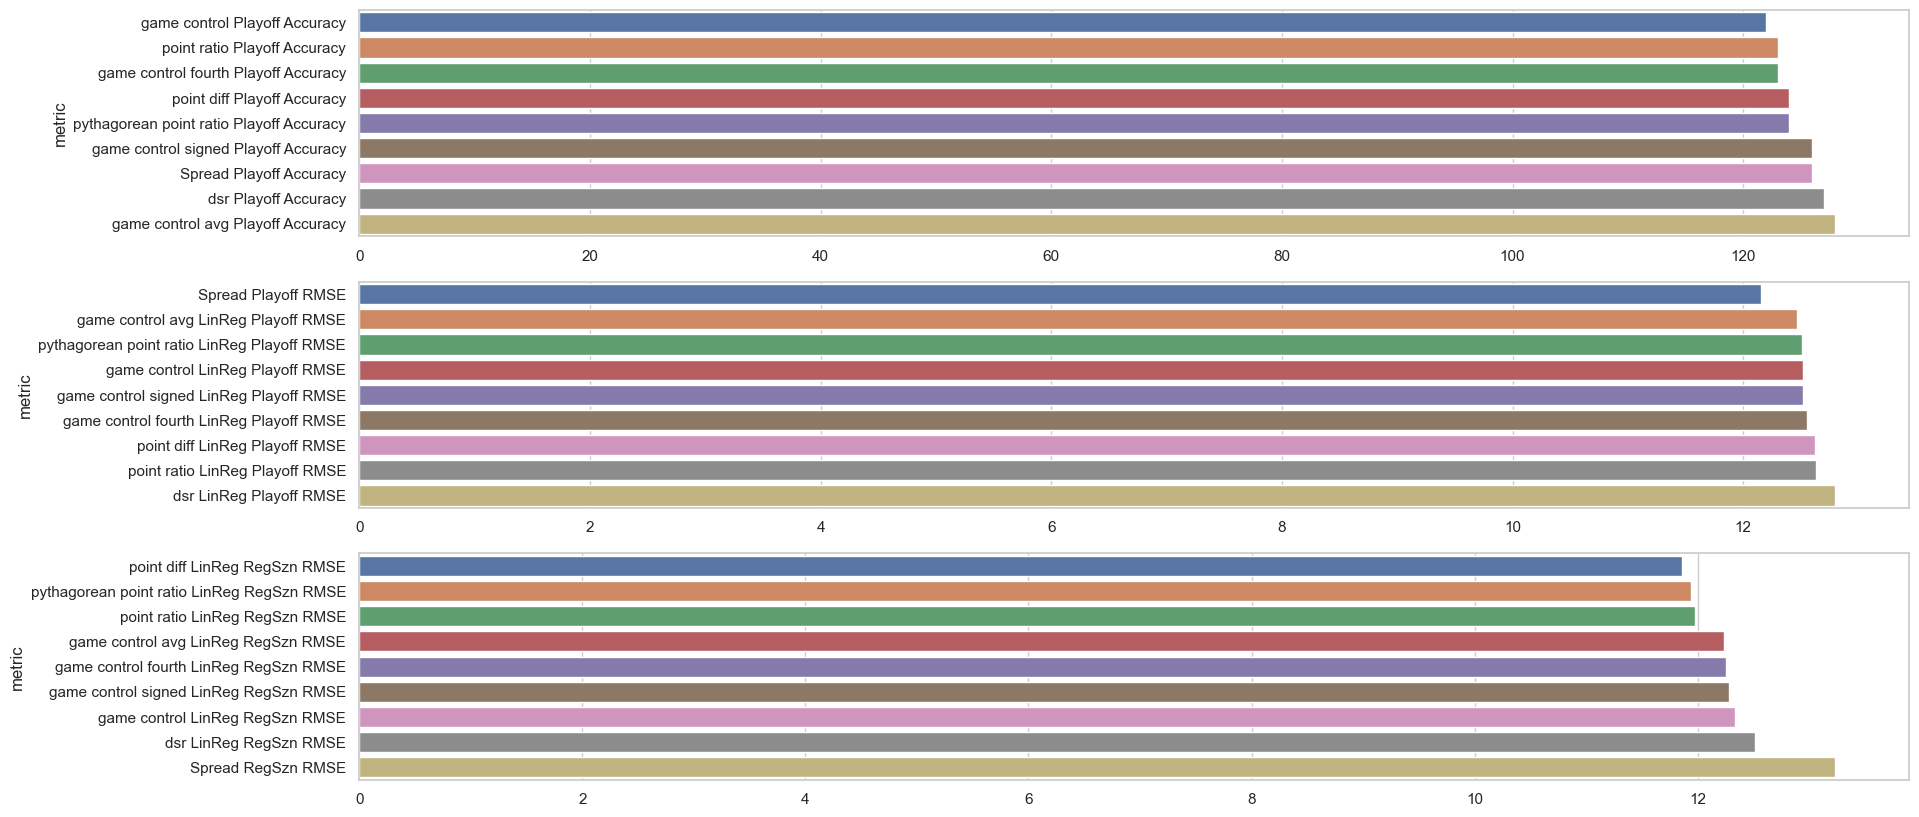

In [29]:
# plot results
fig1 = plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
sns.barplot(y=playoff_acc.index, x=playoff_acc*204)
plt.ylabel('metric')

plt.subplot(3, 1, 2)
sns.barplot(y=playoff_rmse.index, x=playoff_rmse)
plt.ylabel('metric')

plt.subplot(3, 1, 3)
sns.barplot(y=regszn_rmse.index, x=regszn_rmse)
plt.ylabel('metric')

In [30]:
# apply McNemar's test to determine if model differences are statistically significant
predictions = pd.read_csv('data/game_preds.csv').rename({'Unnamed: 0': 'Metric'}, axis=1)
predictions.index = predictions['Metric']
predictions.drop('Metric', axis=1, inplace=True)

for i in range(9): # convert to floats (and last row to bools)
    predictions.iloc[i] = predictions.iloc[i].apply(float)
predictions.iloc[9] = predictions.iloc[9].apply(eval)

table = np.zeros((2,2))
for i in range(8):
    for j in range(i+1, 9):
        table[0][0] = sum((predictions.iloc[i] > 0) & (predictions.iloc[j] > 0))
        table[0][1] = sum((predictions.iloc[i] > 0) & (predictions.iloc[j] < 0))
        table[1][0] = sum((predictions.iloc[i] < 0) & (predictions.iloc[j] > 0))
        table[1][1] = sum((predictions.iloc[i] < 0) & (predictions.iloc[j] < 0))
        print(f'{predictions.iloc[i].name} vs. {predictions.iloc[j].name}: {round(mcnemar(table).pvalue, 4)}')

point diff Playoff Predictions vs. point ratio Playoff Predictions: 0.6636
point diff Playoff Predictions vs. pythagorean point ratio Playoff Predictions: 0.2863
point diff Playoff Predictions vs. dsr Playoff Predictions: 0.324
point diff Playoff Predictions vs. game control Playoff Predictions: 0.5847
point diff Playoff Predictions vs. game control signed Playoff Predictions: 0.5847
point diff Playoff Predictions vs. game control avg Playoff Predictions: 0.8555
point diff Playoff Predictions vs. game control fourth Playoff Predictions: 0.4731
point diff Playoff Predictions vs. Spread Playoff Predictions: 0.0095
point ratio Playoff Predictions vs. pythagorean point ratio Playoff Predictions: 0.0117
point ratio Playoff Predictions vs. dsr Playoff Predictions: 0.6358
point ratio Playoff Predictions vs. game control Playoff Predictions: 0.3713
point ratio Playoff Predictions vs. game control signed Playoff Predictions: 0.3489
point ratio Playoff Predictions vs. game control avg Playoff Pr

In [31]:
# in games where models differed, what is accuracy of each?
for i in range(8):
    for j in range(i+1, 9):
        diff = (predictions.iloc[i] > 0) ^ (predictions.iloc[j] > 0)
        correct = (predictions.iloc[i][diff] > 0) == predictions.loc['Playoff Result'][diff]
        print(f'{predictions.iloc[i].name} vs. {predictions.iloc[j].name}: {sum(correct)}/{sum(diff)} ({round(100*sum(correct) / sum(diff), 1)}%)')

point diff Playoff Predictions vs. point ratio Playoff Predictions: 11/21 (52.4%)
point diff Playoff Predictions vs. pythagorean point ratio Playoff Predictions: 11/22 (50.0%)
point diff Playoff Predictions vs. dsr Playoff Predictions: 17/37 (45.9%)
point diff Playoff Predictions vs. game control Playoff Predictions: 16/30 (53.3%)
point diff Playoff Predictions vs. game control signed Playoff Predictions: 14/30 (46.7%)
point diff Playoff Predictions vs. game control avg Playoff Predictions: 13/30 (43.3%)
point diff Playoff Predictions vs. game control fourth Playoff Predictions: 16/31 (51.6%)
point diff Playoff Predictions vs. Spread Playoff Predictions: 19/40 (47.5%)
point ratio Playoff Predictions vs. pythagorean point ratio Playoff Predictions: 5/11 (45.5%)
point ratio Playoff Predictions vs. dsr Playoff Predictions: 18/40 (45.0%)
point ratio Playoff Predictions vs. game control Playoff Predictions: 23/45 (51.1%)
point ratio Playoff Predictions vs. game control signed Playoff Predic

game_num,point diff,point ratio,pythagorean point ratio,dsr,game control,game control signed,game control avg,game control fourth,Spread Prediction,Playoff Result Spread
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,4.151560,3.828145,3.972187,3.377761,4.243892,4.145796,3.997650,4.053282,4.257353,3.563725
std,6.499237,5.695201,5.550560,5.541231,6.044347,6.102439,6.005134,5.648045,4.690541,13.086332
min,-11.314276,-9.349578,-10.540461,-11.073814,-14.452640,-13.429735,-13.329304,-10.289226,-10.000000,-35.000000
25%,-0.019723,-0.207831,0.528700,-0.830270,0.219667,0.496747,0.242495,0.535531,2.500000,-4.000000
50%,4.175204,4.402444,4.297554,3.519399,4.532038,4.298010,4.105193,4.189784,4.000000,3.000000
75%,8.821746,7.635157,7.791870,7.277176,8.217451,8.268915,8.171572,7.925003,7.500000,13.000000
max,23.654733,17.901985,18.709624,18.905743,19.932655,19.616102,19.084243,21.764355,16.000000,38.000000


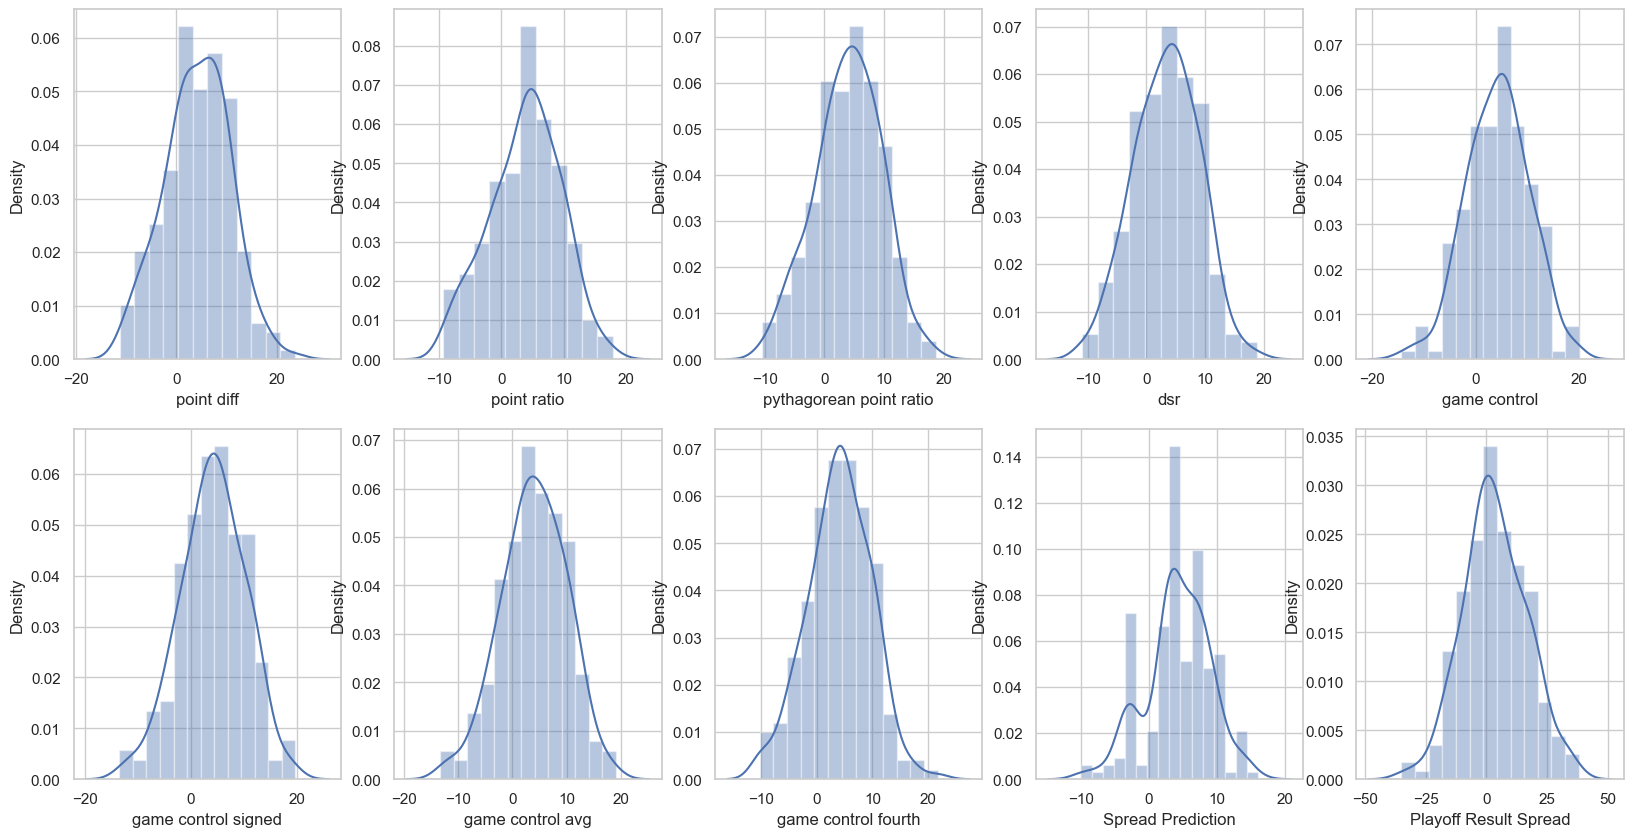

In [168]:
# distribution of each regressor's playoff predictions (do some tend to predict larger numbers? dist of difference vs actual?)

predictors = game_preds.drop(['Year', 'Playoff Result'], axis=1).applymap(float)
plt.figure(figsize=(20,10))

for i in range(len(predictors.columns)):
    plt.subplot(2, 5, i+1)
    sns.distplot(predictors.iloc[:, i])

predictors.describe()

In [139]:
# try nonlinear combinations of the 8 LRMC models

# decision tree for playoff prediction (in: predicted spread of each linear regression, out: exp winner home/away)

linr_preds = pd.read_csv('data/linr_preds.csv').rename({'Unnamed: 0': 'game_num'}, axis=1).T # regszn
linr_preds.columns = linr_preds.iloc[0]
linr_preds.drop('game_num', inplace=True)

game_preds = pd.read_csv('data/game_preds.csv').rename({'Unnamed: 0': 'game_num'}, axis=1).T # playoffs
game_preds.columns = game_preds.iloc[0]
game_preds.drop('game_num', inplace=True)

total = 0
for i in range(2005, 2022+1):
    regszn_games = linr_preds.groupby('Year').get_group(i)
    regszn_games = regszn_games[regszn_games['Result'] != 0] # fit on all games with non-tie outcome
    train_X = regszn_games.drop(['Year', 'Result'], axis=1) # fit decision tree to regression preds for season i regszn games and outcomes
    train_Y = regszn_games['Result'] > 0

    playoff_games = game_preds.groupby('Year').get_group(str(i))
    test_X = playoff_games.drop(['Spread Prediction', 'Playoff Result', 'Year', 'Playoff Result Spread'], axis=1).applymap(float)
    test_Y = playoff_games['Playoff Result'].apply(bool) # test decision tree on playoff games for that season

    tree_clf = DecisionTreeClassifier(max_depth=8, random_state=0).fit(train_X, train_Y)
    #print(f'{i}: {tree_clf.score(test_X, test_Y)}')
    print(f'{i}: {int(tree_clf.score(test_X, test_Y)*len(test_Y))} / {len(test_Y)}')
    total += int(tree_clf.score(test_X, test_Y)*len(test_Y))

print(f'Total: {total} / 204 = {total / 204}')

2005: 9 / 11
2006: 7 / 11
2007: 7 / 11
2008: 5 / 11
2009: 3 / 11
2010: 7 / 11
2011: 8 / 11
2012: 8 / 11
2013: 7 / 11
2014: 7 / 11
2015: 5 / 11
2016: 11 / 11
2017: 4 / 11
2018: 7 / 11
2019: 5 / 11
2020: 9 / 13
2021: 6 / 13
2022: 12 / 13
Total: 127 / 204 = 0.6225490196078431


Total: 142.0 / 204 = 0.696078431372549


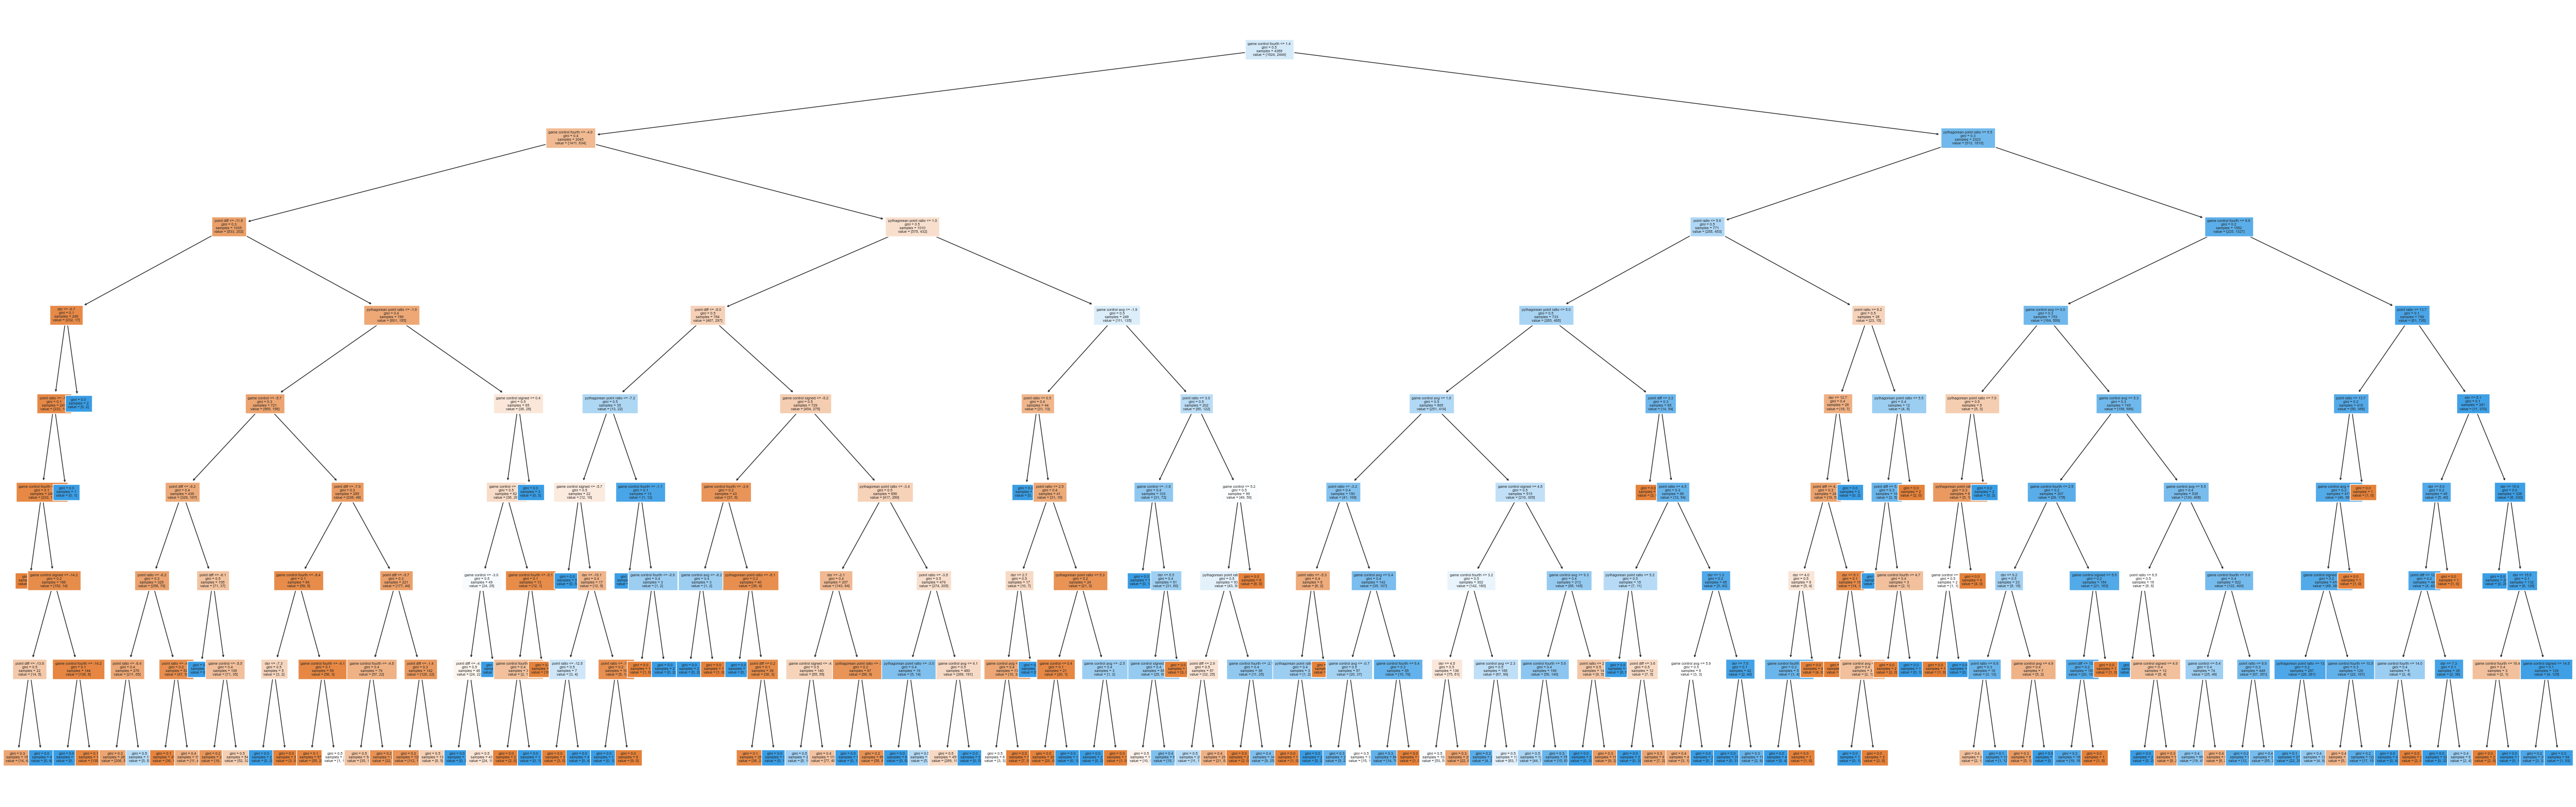

In [220]:
# fit decision tree to output of linear regressors on every regular season game from 2005-2022 and evaluate on playoffs

regszn_games = linr_preds
regszn_games = regszn_games[regszn_games['Result'] != 0] # fit on all games with non-tie outcome
train_X = regszn_games.drop(['Year', 'Result'], axis=1) # fit decision tree to regression preds for all season regszn games and outcomes
train_Y = regszn_games['Result'] > 0

playoff_games = game_preds
test_X = playoff_games.drop(['Spread Prediction', 'Playoff Result', 'Year', 'Playoff Result Spread'], axis=1).applymap(float)
test_Y = playoff_games['Playoff Result'].apply(bool) # test decision tree on playoff games for that season

tree_clf = DecisionTreeClassifier(max_depth=8, random_state=0).fit(train_X, train_Y)
print(f'Total: {tree_clf.score(test_X, test_Y) * 204} / 204 = {tree_clf.score(test_X, test_Y)}')

# plot tree (left is True for direction, left is False for leaf result)
plt.figure(figsize=(64, 20))
plot_tree(tree_clf, fontsize=5, feature_names=train_X.columns, precision=1, filled=True)
plt.savefig('results/decision_tree.png', dpi=100)

In [209]:
# fit decision tree to output of linear regressors on all playoff games from 2005-2016 and evaluate on playoffs from 2017-2022

playoff_games = game_preds.drop(['Spread Prediction', 'Playoff Result Spread'], axis=1)
playoff_games['Year'] = playoff_games['Year'].apply(float)
train_X = playoff_games[playoff_games['Year'].isin(range(2005, 2016+1))].drop(['Playoff Result', 'Year'], axis=1).applymap(float)
train_Y = playoff_games[playoff_games['Year'].isin(range(2005, 2016+1))]['Playoff Result']

test_X = playoff_games[playoff_games['Year'].isin(range(2017, 2022+1))].drop(['Playoff Result', 'Year'], axis=1).applymap(float)
test_Y = playoff_games[playoff_games['Year'].isin(range(2017, 2022+1))]['Playoff Result']

tree_clf = DecisionTreeClassifier(max_depth=8, random_state=0).fit(train_X, train_Y)
print(f'{int(tree_clf.score(test_X, test_Y)*len(test_X))} / {len(test_X)} = {tree_clf.score(test_X, test_Y)}')

38 / 72 = 0.5277777777777778


In [211]:
# fit as before, but with spread prediction included as a predictor

playoff_games = game_preds.drop(['Playoff Result Spread'], axis=1)
playoff_games['Year'] = playoff_games['Year'].apply(float)
train_X = playoff_games[playoff_games['Year'].isin(range(2005, 2016+1))].drop(['Playoff Result', 'Year'], axis=1).applymap(float)
train_Y = playoff_games[playoff_games['Year'].isin(range(2005, 2016+1))]['Playoff Result']

test_X = playoff_games[playoff_games['Year'].isin(range(2017, 2022+1))].drop(['Playoff Result', 'Year'], axis=1).applymap(float)
test_Y = playoff_games[playoff_games['Year'].isin(range(2017, 2022+1))]['Playoff Result']

tree_clf = DecisionTreeClassifier(max_depth=9, random_state=0).fit(train_X, train_Y)
print(f'{int(tree_clf.score(test_X, test_Y)*len(test_X))} / {len(test_X)} = {tree_clf.score(test_X, test_Y)}')

43 / 72 = 0.5972222222222222
